This is a simple starter notebook to help you get started with the hackathon



In [1]:
# import libraries
import os
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set seed for reproducability
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)


## Loading and previewing data

In [3]:
DATA_PATH = ''
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'SampleSubmission.csv'))
weather_df = pd.read_csv(os.path.join(DATA_PATH, 'Accra_weather.csv'), index_col=0)
variable_def = pd.read_csv(os.path.join(DATA_PATH, 'VariableDefinitions.csv'))

In [4]:
variable_def

,Attribute,Description
0,trip_id,Unique identifier for the trip
1,lcl_start_transporting_dt,Local date when the trip started
2,lcl_start_transporting_dttm,Local date and time when the trip started
3,lcl_order_finished_dttm,Local date and time when the trip ended
4,transporting_time_fact_mnt,Actual travel time in minutes
5,transporting_distance_fact_km,Actual travel distance in kilometers
6,str_distance_km,Straight-line distance in kilometers
7,origin_lat,Latitude of the starting point
8,origin_lon,Longitude of the starting point
9,destination_lat,Latitude of the destination point


In [5]:
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23


In [6]:
test.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km
0,ID_PV4QVE2H2X,5.659192,-0.128552,2024-05-28,2024-05-28 12:05:02,5.656207,-0.134396,0.673,1.241
1,ID_SUOBMO2E7V,5.664648,-0.143562,2024-05-07,2024-05-07 14:49:53,5.652780,-0.153714,1.802,2.650
2,ID_Q5KSL38U9B,5.642269,-0.152571,2024-05-18,2024-05-18 22:04:02,5.665573,-0.126283,3.833,6.015
3,ID_1G08NWYA35,5.695806,-0.118942,2024-05-25,2024-05-25 05:18:49,5.678735,-0.172577,6.219,7.987
4,ID_H7IZ8JL8YT,5.561824,-0.199377,2024-05-29,2024-05-29 16:55:24,5.551920,-0.196771,1.138,2.078


In [7]:
samplesubmission.head()

,trip_id,Target
0,ID_AH24RTKUMM,0
1,ID_1UH56FLC88,0
2,ID_014VH4SGZI,0
3,ID_J8HIZ307LQ,0
4,ID_ER6CPWJQ17,0


In [8]:
weather_df.head()

,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C
lcl_date,,,,
2024-05-01,2024-05-01 00:00:00,Rain,0.001907,28.54
2024-05-01,2024-05-01 01:00:00,Rain,0.002861,28.51
2024-05-01,2024-05-01 02:00:00,Rain,0.002861,28.51
2024-05-01,2024-05-01 03:00:00,Rain,0.000954,28.53
2024-05-01,2024-05-01 04:00:00,Rain,0.001907,28.60


In [9]:
def extract_datetime_features(data, cols: list):
    df = data.copy()
    for col in cols:
        df[col] = pd.to_datetime(df[col])
        df[f'{col}_hour'] = df[col].dt.hour
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_month'] = df[col].dt.month

    return df

In [10]:
# extract datetime features
train = extract_datetime_features(train, ['lcl_start_transporting_dttm'])
test = extract_datetime_features(test, ['lcl_start_transporting_dttm'])
weather_df = extract_datetime_features(weather_df, ['lcl_datetime'])

# Preview train dataset
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18,9,5,5
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93,10,21,5
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02,21,5,5
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80,21,26,5
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23,14,30,5


In [11]:
# Preview test dataset
test.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
0,ID_PV4QVE2H2X,5.659192,-0.128552,2024-05-28,2024-05-28 12:05:02,5.656207,-0.134396,0.673,1.241,12,28,5
1,ID_SUOBMO2E7V,5.664648,-0.143562,2024-05-07,2024-05-07 14:49:53,5.652780,-0.153714,1.802,2.650,14,7,5
2,ID_Q5KSL38U9B,5.642269,-0.152571,2024-05-18,2024-05-18 22:04:02,5.665573,-0.126283,3.833,6.015,22,18,5
3,ID_1G08NWYA35,5.695806,-0.118942,2024-05-25,2024-05-25 05:18:49,5.678735,-0.172577,6.219,7.987,5,25,5
4,ID_H7IZ8JL8YT,5.561824,-0.199377,2024-05-29,2024-05-29 16:55:24,5.551920,-0.196771,1.138,2.078,16,29,5


In [12]:
# Preview sample submission file
samplesubmission.head()

,trip_id,Target
0,ID_AH24RTKUMM,0
1,ID_1UH56FLC88,0
2,ID_014VH4SGZI,0
3,ID_J8HIZ307LQ,0
4,ID_ER6CPWJQ17,0


In [13]:
# Preview graph data
weather_df.head()

,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month
lcl_date,,,,,,,
2024-05-01,2024-05-01 00:00:00,Rain,0.001907,28.54,0,1,5
2024-05-01,2024-05-01 01:00:00,Rain,0.002861,28.51,1,1,5
2024-05-01,2024-05-01 02:00:00,Rain,0.002861,28.51,2,1,5
2024-05-01,2024-05-01 03:00:00,Rain,0.000954,28.53,3,1,5
2024-05-01,2024-05-01 04:00:00,Rain,0.001907,28.60,4,1,5


In [14]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((57596, 13), (24684, 12), (24684, 2))

In [15]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.3


## Statistical summaries

In [16]:
# Train statistical summary
train.describe(include = 'number')  # could also do include = 'all' or 'object'

,destination_lat,destination_lon,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
count,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000,57596.000000
mean,5.644267,-0.169131,5.644717,-0.169566,1.856562,3.170373,10.084202,13.591465,16.342645,5.000122
std,0.044116,0.041993,0.043378,0.041983,1.564909,2.855521,8.902421,5.493301,8.883002,0.011024
min,5.526851,-0.354872,5.527981,-0.349419,0.000000,0.501000,1.020000,0.000000,1.000000,5.000000
25%,5.622134,-0.187408,5.622675,-0.186448,0.934000,1.599000,5.270000,10.000000,9.000000,5.000000
50%,5.656059,-0.167765,5.657558,-0.167834,1.447000,2.379000,7.710000,14.000000,16.000000,5.000000
75%,5.675784,-0.149920,5.675472,-0.150483,2.245000,3.742000,12.030000,18.000000,24.000000,5.000000
max,5.754841,-0.047629,5.752558,-0.048585,18.120000,90.428000,585.930000,23.000000,31.000000,6.000000


Some insights from the above summary:
 - The train data provided has 57 596 data points
 - The average trip time is 10.08 mins
 - The shortest trip took a 1.02 minute while the longest took 585.93 mins (possible outliers)

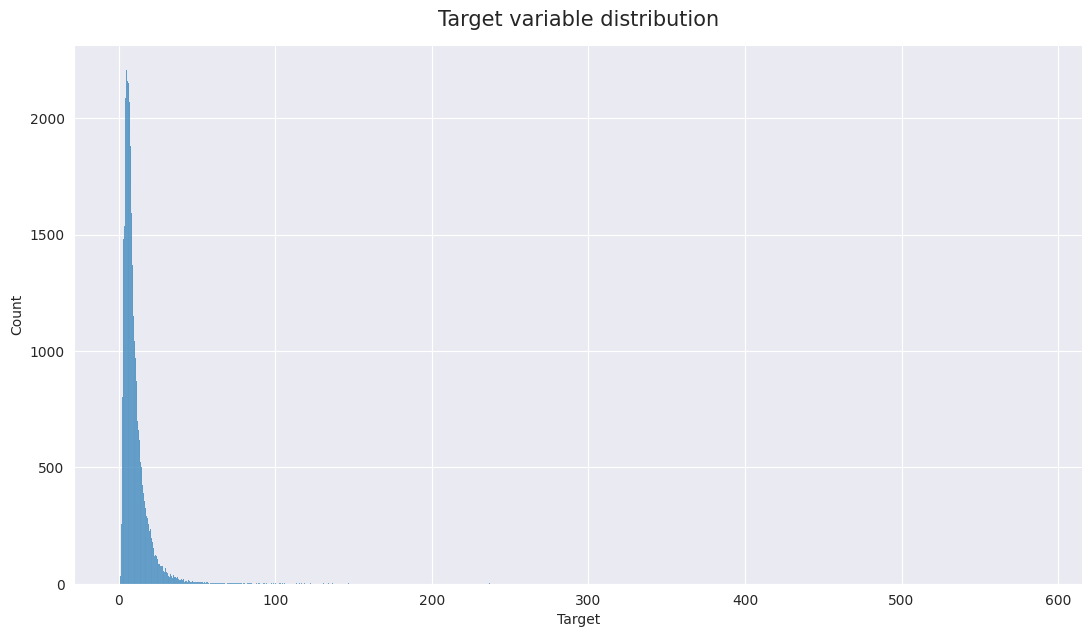

None

np.float64(10.334243815626118)

In [17]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.Target)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.Target.skew())

The target variable appears to be right skewed




## Outliers


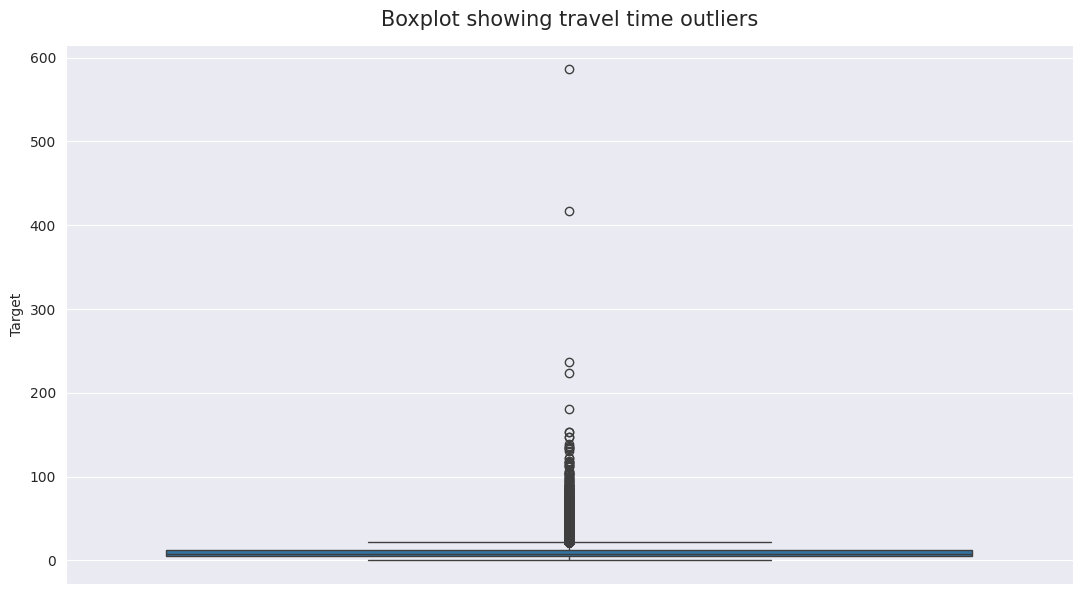

In [18]:
# Plotting boxplot for travel time
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.Target)
plt.title('Boxplot showing travel time outliers', y = 1.02, fontsize = 15)
plt.show()

Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...



## Weather data

In [19]:
weather_df.lcl_datetime.min(), weather_df.lcl_datetime.max()

(Timestamp('2024-05-01 00:00:00'), Timestamp('2024-05-31 23:00:00'))

In [20]:
weather_df.describe(include='all')

,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month
count,744,744,744.000000,744.000000,744.000000,744.000000,744.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,Rain,NaN,NaN,NaN,NaN,NaN
freq,NaN,682,NaN,NaN,NaN,NaN,NaN
mean,2024-05-16 11:29:59.999999744,NaN,0.151697,28.299825,11.500000,16.000000,5.0
min,2024-05-01 00:00:00,NaN,0.000000,25.920000,0.000000,1.000000,5.0
25%,2024-05-08 17:45:00,NaN,0.000954,27.650000,5.750000,8.000000,5.0
50%,2024-05-16 11:30:00,NaN,0.012398,28.400000,11.500000,16.000000,5.0
75%,2024-05-24 05:15:00,NaN,0.076294,29.010000,17.250000,24.000000,5.0
max,2024-05-31 23:00:00,NaN,4.338264,30.490000,23.000000,31.000000,5.0


Some insights from the above summary:

 - An average of 0.151mm of precipitation was recorded in May 2024
 - Highest precipitation was 4.34mm
 - Average temp in May was 28.30 deg Celcius with a range between 25.92 and 30.49 degrees Celcius


Let's merge the weather and trips data

In [21]:
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18,9,5,5
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93,10,21,5
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02,21,5,5
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80,21,26,5
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23,14,30,5


In [22]:
# create day_hour variable to merge trips and weather data on
train['day_hour'] = train['lcl_start_transporting_dttm_day'].astype(str).str.split('.').str[0] +\
 '_' + train['lcl_start_transporting_dttm_hour'].astype(str).str.split('.').str[0]

test['day_hour'] = test['lcl_start_transporting_dttm_day'].astype(str).str.split('.').str[0] +\
 '_' + test['lcl_start_transporting_dttm_hour'].astype(str).str.split('.').str[0]

weather_df['day_hour'] = weather_df['lcl_datetime_day'].astype(str).str.split('.').str[0] +\
 '_' + weather_df['lcl_datetime_hour'].astype(str).str.split('.').str[0]

In [23]:
train = train.merge(weather_df, on='day_hour', how='left')
test = test.merge(weather_df, on='day_hour', how='left')

In [24]:
train.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,Target,...,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month,day_hour,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month
0,ID_S3BD1V9G53,5.630927,-0.169211,2024-05-05,2024-05-05 09:56:32,5.630979,-0.164760,0.529,0.850,2.18,...,5,5,5_9,2024-05-05 09:00:00,Rain,0.012875,28.74,9,5,5
1,ID_ZJM7LMN65Q,5.645044,-0.156482,2024-05-21,2024-05-21 10:53:32,5.686892,-0.118931,6.230,8.720,20.93,...,21,5,21_10,2024-05-21 10:00:00,Rain,0.001907,29.32,10,21,5
2,ID_SZ3BP6V01V,5.711156,-0.141063,2024-05-05,2024-05-05 21:21:21,5.706008,-0.164999,2.705,3.239,13.02,...,5,5,5_21,2024-05-05 21:00:00,Rain,0.001907,29.54,21,5,5
3,ID_5IPHXDCMKF,5.677497,-0.183350,2024-05-26,2024-05-26 21:23:33,5.665943,-0.182602,1.236,1.410,3.80,...,26,5,26_21,2024-05-26 21:00:00,No precipitation,0.000000,28.49,21,26,5
4,ID_BYZEJ0B5RA,5.601700,-0.173589,2024-05-30,2024-05-30 14:02:13,5.565401,-0.160919,4.312,6.553,17.23,...,30,5,30_14,2024-05-30 14:00:00,No precipitation,0.019073,29.38,14,30,5


In [25]:
test.head()

,trip_id,destination_lat,destination_lon,lcl_start_transporting_dt,lcl_start_transporting_dttm,origin_lat,origin_lon,str_distance_km,transporting_distance_fact_km,lcl_start_transporting_dttm_hour,lcl_start_transporting_dttm_day,lcl_start_transporting_dttm_month,day_hour,lcl_datetime,precipitation_type,prev_hour_precipitation_mm,temperature_C,lcl_datetime_hour,lcl_datetime_day,lcl_datetime_month
0,ID_PV4QVE2H2X,5.659192,-0.128552,2024-05-28,2024-05-28 12:05:02,5.656207,-0.134396,0.673,1.241,12,28,5,28_12,2024-05-28 12:00:00,Rain,0.000954,29.65,12,28,5
1,ID_SUOBMO2E7V,5.664648,-0.143562,2024-05-07,2024-05-07 14:49:53,5.652780,-0.153714,1.802,2.650,14,7,5,7_14,2024-05-07 14:00:00,Rain,0.002861,28.64,14,7,5
2,ID_Q5KSL38U9B,5.642269,-0.152571,2024-05-18,2024-05-18 22:04:02,5.665573,-0.126283,3.833,6.015,22,18,5,18_22,2024-05-18 22:00:00,No precipitation,0.000000,28.58,22,18,5
3,ID_1G08NWYA35,5.695806,-0.118942,2024-05-25,2024-05-25 05:18:49,5.678735,-0.172577,6.219,7.987,5,25,5,25_5,2024-05-25 05:00:00,Rain,1.291275,26.89,5,25,5
4,ID_H7IZ8JL8YT,5.561824,-0.199377,2024-05-29,2024-05-29 16:55:24,5.551920,-0.196771,1.138,2.078,16,29,5,29_16,2024-05-29 16:00:00,Rain,0.000000,29.24,16,29,5



## Missing values and duplicates

In [26]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(np.False_, np.False_)

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [27]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(np.False_, np.False_)


## Correlations

In [28]:
# Top 20 correlated features to the target
top20_corrs = abs(train.select_dtypes(include='number').corr()['Target']).sort_values(ascending = False).head(20)
top20_corrs

,Target
Target,1.000000
transporting_distance_fact_km,0.831081
str_distance_km,0.455688
origin_lon,0.037094
destination_lon,0.026450
lcl_start_transporting_dttm_hour,0.024966
lcl_datetime_hour,0.024966
origin_lat,0.017035
lcl_datetime_day,0.011372
lcl_start_transporting_dttm_day,0.011372


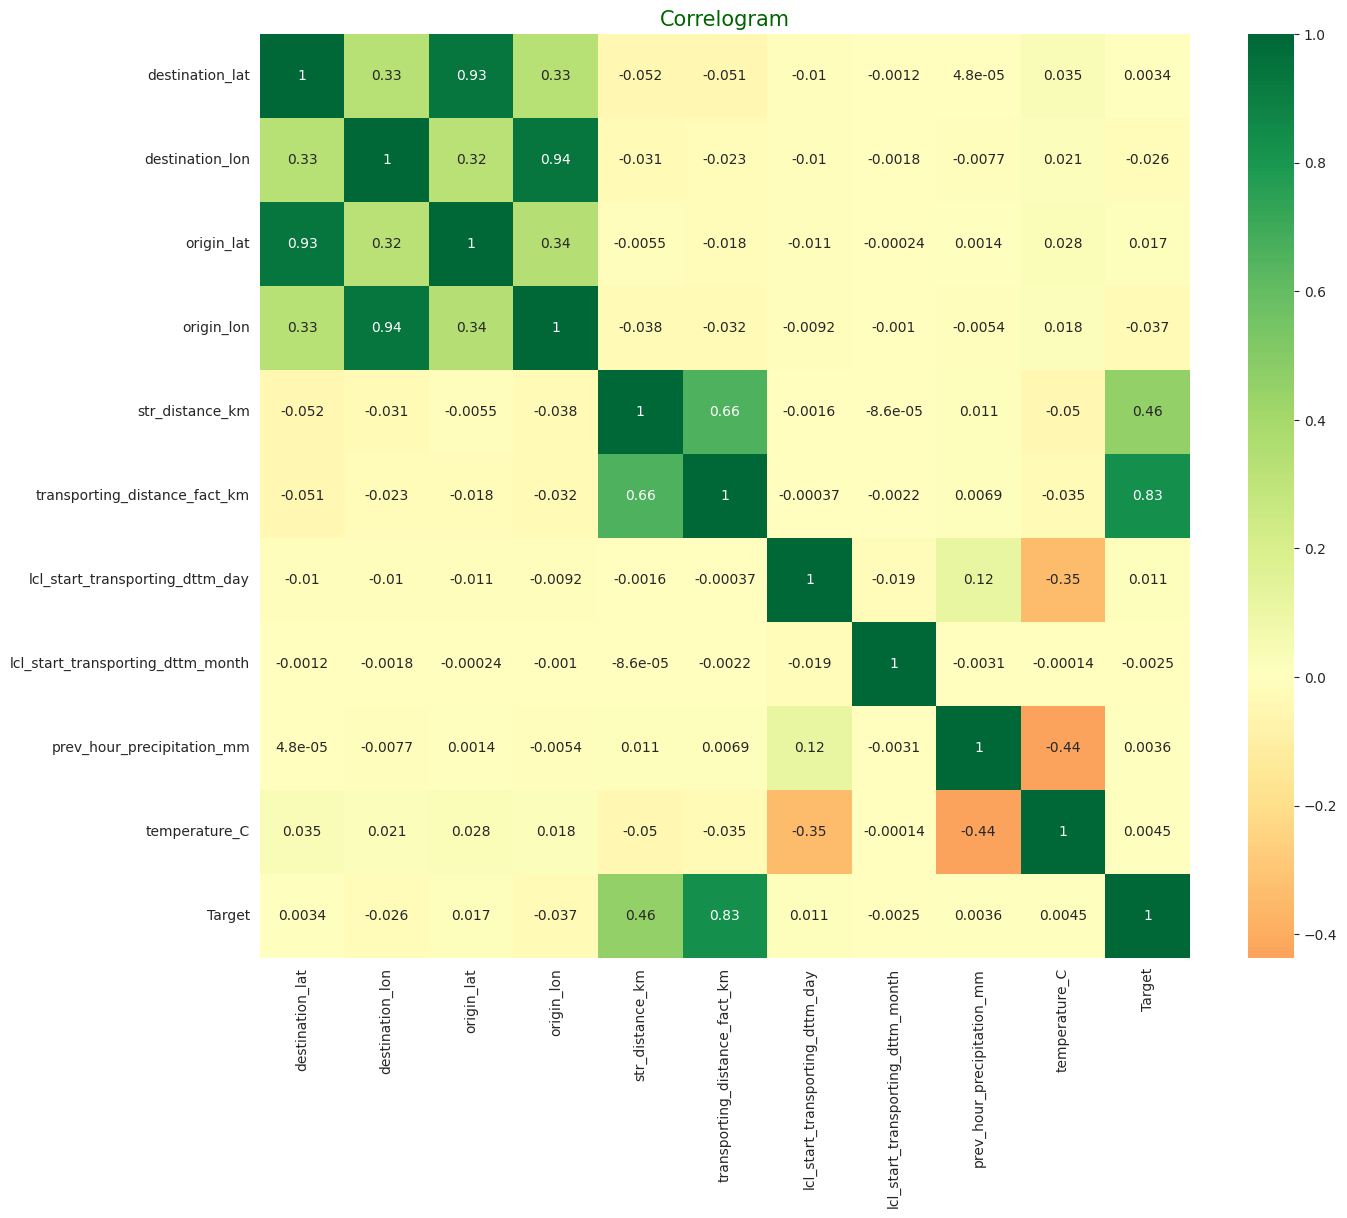

In [29]:
cols = ['destination_lat','destination_lon','origin_lat','origin_lon',
        'str_distance_km','transporting_distance_fact_km', 'lcl_start_transporting_dttm_day',
        'lcl_start_transporting_dttm_month', 'prev_hour_precipitation_mm', 'temperature_C', 'Target']

# Plotting a heatmap to show correlations between variables
corr = train[cols].corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()


## Modelling

In [30]:
# Selecting the independent variables and the target variable
feature_cols = ['str_distance_km', 'temperature_C','transporting_distance_fact_km',
           'lcl_start_transporting_dttm_day', 'prev_hour_precipitation_mm']
X = train[feature_cols].fillna(0)
y = train.Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {np.sqrt(mean_squared_error(y_test, y_pred))}')

RMSE Score: 4.472809533648588


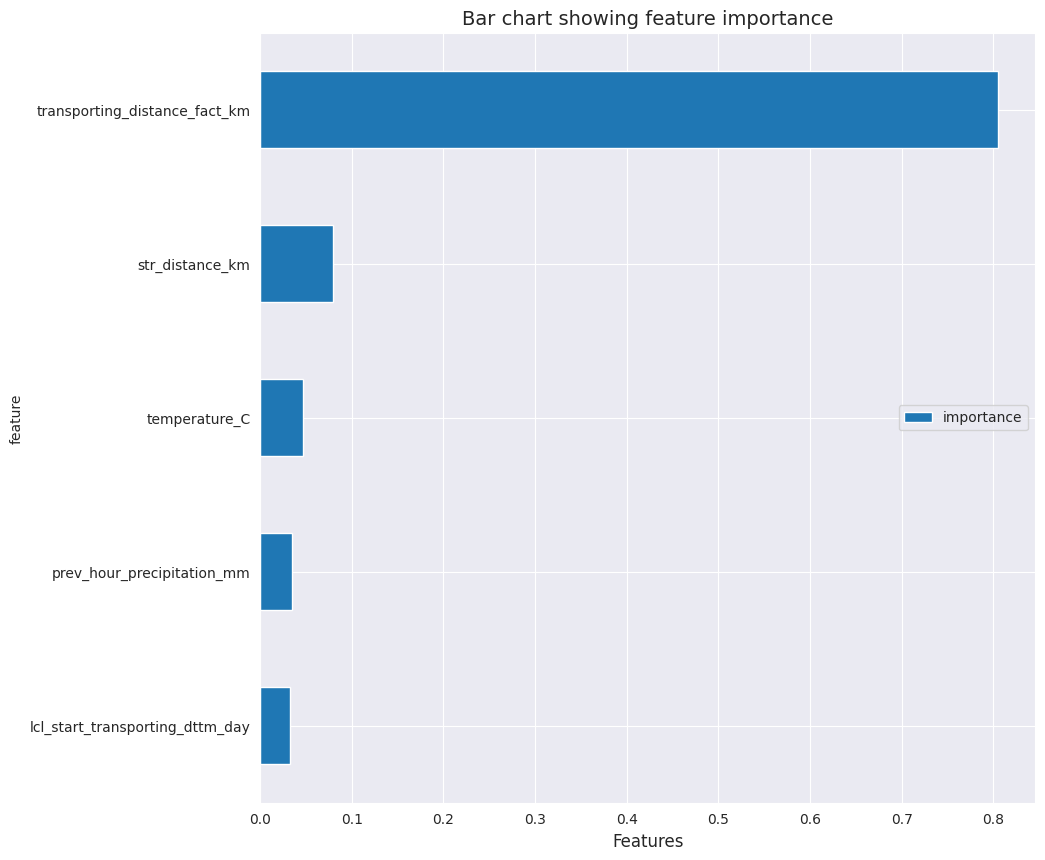

In [31]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()


## Making predictions of the test set and creating a submission file

In [32]:
# Make prediction on the test set
test_df = test[feature_cols].fillna(0)
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'trip_id': test.trip_id, 'Target': predictions})
sub_file.head()

,trip_id,Target
0,ID_PV4QVE2H2X,4.7070
1,ID_SUOBMO2E7V,9.0229
2,ID_Q5KSL38U9B,18.5745
3,ID_1G08NWYA35,18.3903
4,ID_H7IZ8JL8YT,8.6596


In [33]:
# Create file
sub_file.to_csv('BaselineSubmission.csv', index = False) # Download subfile and submit to zindi for scoring

## ALL THE BEST AND HAVE FUN &#x1F60E;